In [37]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import sklearn.metrics as metrics
from meld_graph.evaluation import load_prediction, sens_spec_curves, roc_curves, plot_roc_multiple
import pandas as pd
import itertools
import seaborn as sns

In [8]:
# set model path
model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-03-06_WELH_classification_distance/s_0'
save_dirs = [os.path.join(model_name,f'fold_0{fold}', 'results') for fold in np.arange(5)]
pred_fname = 'predictions_trainval.hdf5'

In [9]:
# load cohort
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')

In [12]:
def load_predictions_for_subject(subj, save_dirs, cohort, pred_fname='predictions.h5ad'):
    """
    Load and ensemble subject data. Returns subject_dict with keys "input_labels", "borderzone", "result"
    
    Args:
        subj: subject string
        save_dirs: list of models (folds) that should be loaded & ensembled
        cohort: MeldCohort
    """
    s = MeldSubject(subj,cohort=cohort)
    
    # load labels & borderzone
    labels_hemis = {}
    dists = {}
    for hemi in ['lh', 'rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(features=['.on_lh.boundary_zone.mgh'], 
                                                                     hemi=hemi, features_to_ignore=[])
        if np.sum(dists[hemi])==0:
                dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    
    # load predictions
    subject_results = []
    subject_dists = []
    n_folds = len(save_dirs)
    for fold in np.arange(n_folds):
        pred_file = os.path.join(save_dirs[fold], pred_fname)
        result_hemis = load_prediction(subj,pred_file, dset='prediction')
        distance_hemis = load_prediction(subj, pred_file, dset='distance_map')
        subject_results.append(np.hstack([result_hemis['lh'],result_hemis['rh']]))
        subject_dists.append(np.hstack([distance_hemis['lh'],distance_hemis['rh']]))
    # ensemble predictions
    if n_folds > 1:
        m_subject_results = np.mean(subject_results,axis=0)
        m_subject_dists = np.mean(subject_dists,axis=0)
    else:
        m_subject_results = subject_results[0]
        m_subject_dists = subject_dists[0]
    
    # build results dict
    subject_dictionary={'input_labels':labels,'borderzone':borderzones,'result':m_subject_results,
                        'distance_map':m_subject_dists}
    return subject_dictionary
        


In [13]:
# get list of subjects 
with h5py.File(os.path.join(save_dirs[0], pred_fname), "r") as f:
    subjects = list(f.keys())
    
# load and ensemble individual subject predictions over folds
subjects_dict = []
for subj in subjects:
    subjects_dict.append(load_predictions_for_subject(subj, save_dirs, cohort, pred_fname))
    

(array([147.,  22.,  26.,   4.,  21.,  14.,  32.,  49.,  59.,  84.]),
 array([-0.06319676,  0.03088348,  0.12496371,  0.21904394,  0.31312418,
         0.4072044 ,  0.50128466,  0.59536487,  0.6894451 ,  0.78352535,
         0.87760556], dtype=float32),
 <BarContainer object of 10 artists>)

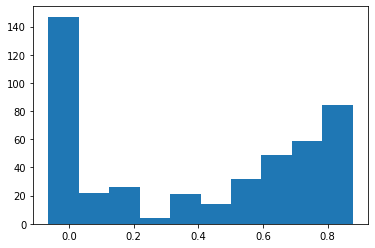

In [14]:
min_dist = [s['distance_map'].min() for s in subjects_dict]
plt.hist(min_dist)

(array([5.7000e+01, 3.7310e+03, 3.4527e+04, 2.7081e+04, 2.3793e+04,
        4.1210e+04, 6.0227e+04, 5.7496e+04, 4.5421e+04, 2.6100e+02]),
 array([0.40372008, 0.46574762, 0.52777517, 0.58980274, 0.65183026,
        0.71385777, 0.77588534, 0.8379129 , 0.89994043, 0.96196795,
        1.0239955 ], dtype=float32),
 <BarContainer object of 10 artists>)

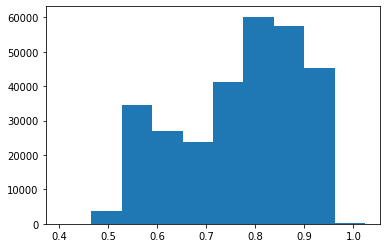

In [15]:
plt.hist(subjects_dict[1]['distance_map'])

(array([  5511.,  18828.,  24155.,  23244.,  30029.,  27433.,  15399.,
          2308., 106895.,  40002.]),
 array([0.06183542, 0.15804498, 0.25425455, 0.3504641 , 0.44667366,
        0.5428832 , 0.6390928 , 0.7353023 , 0.8315119 , 0.92772144,
        1.023931  ], dtype=float32),
 <BarContainer object of 10 artists>)

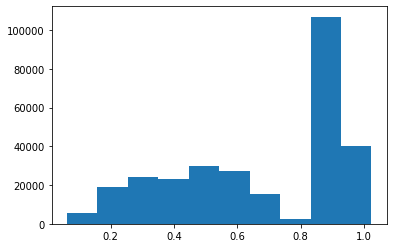

In [16]:
plt.hist(subjects_dict[2]['distance_map'])

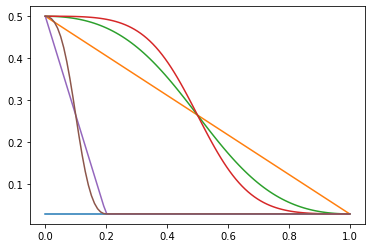

In [39]:
# define sigmoid functions to find threshold in function of min distance
def sigmoid(x, k=2, m=0.5, ymin=0.03, ymax=0.5):
    """
    Inverse sigmoid function with fixed endpoints ymin and ymax, variable midpoint m and slope k.
    Function has the following properties: f(0)=ymax, f(1)=ymin (except for k=0, where f(x)=ymin)
    
    Shifting the midpoint will squeeze the function in the range 0,2*midpoint, and set all values beyond to ymin.
    
    Args:
        x: input values that should be transformed
        k: slope
        m: midpoint
        ymin: min value
        ymax: max value
    """
    xmax = m*2
    # inverse sigmoid function with fixed endpoints and variable slope k
    # k = 0 defaults to ymin
    if k == 0:
        return np.ones_like(x)*ymin
    eps = 1e-15
    res = 1 / (1 + (1/(x/xmax+eps)-1)**(-k))
    # scale y range
    scaled_res = res * (ymax - ymin) + ymin
    # clip values of x > xmax to ymin
    scaled_res[x > xmax] = ymin
    return scaled_res



plt.plot(np.linspace(0,1,100), sigmoid(np.linspace(0,1,100), 0, 0.5))
plt.plot(np.linspace(0,1,100), sigmoid(np.linspace(0,1,100), 1, 0.5))
plt.plot(np.linspace(0,1,100), sigmoid(np.linspace(0,1,100), 2, 0.5))
plt.plot(np.linspace(0,1,100), sigmoid(np.linspace(0,1,100), 3, 0.5))

plt.plot(np.linspace(0,1,100), sigmoid(np.linspace(0,1,100), 1, 0.1))
plt.plot(np.linspace(0,1,100), sigmoid(np.linspace(0,1,100), 2, 0.1))

1.0
0.2


(array([280.,   4.,   8.,   0.,   4.,   1.,   4.,   4.,   3., 150.]),
 array([0.03 , 0.077, 0.124, 0.171, 0.218, 0.265, 0.312, 0.359, 0.406,
        0.453, 0.5  ], dtype=float32),
 <BarContainer object of 10 artists>)

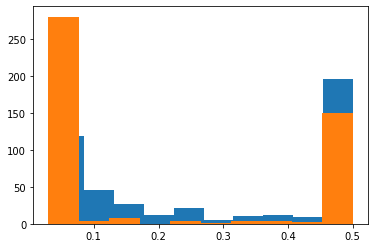

In [35]:
# set example thresholds
thresholds = sigmoid(np.array(min_dist), k=2)
plt.hist(thresholds)

thresholds = sigmoid(np.array(min_dist), k=2, m=0.1)
plt.hist(thresholds)

In [36]:
def get_scores(subjects_dict, thresholds):
    """
    return sensitivity & dice for given threshold
    TODO should use our own dice + sens functions in meld_graph
    """
    patient_sens = []
    dice = []
    for subj, thresh in zip(subjects_dict, thresholds):
        tp = ((subj['input_labels'] == 1) & (subj['result'] > thresh)).sum()
        fp = ((subj['input_labels'] == 0) & (subj['result'] > thresh)).sum()
        #tn = ((subj['input_labels'] == 0) & (subj['result'] <= thresh)).sum()
        fn = ((subj['input_labels'] == 1) & (subj['result'] <= thresh)).sum()
        
        dice.append(2*tp / (2*tp + fp + fn + 1e-15))
        if sum(subj['input_labels']) != 0:
            patient_sens.append(tp > 1)
    return np.mean(dice), np.mean(patient_sens)

In [52]:
# iterate over a few thresholds (k=0 is current standard)
# calculate threshold as a function of min dist
min_dist = [s['distance_map'].min() for s in subjects_dict]

res = [] #{'dice':[], 'sensitivity':[], 'k':[], 'm':[], 'desc':[]}
for k,m in itertools.product([1,2],[0.5,0.3,0.1,0.05]):
    print(k,m)
    thresholds = sigmoid(np.array(min_dist), k=k, m=m)
    cur_dice, cur_sens = get_scores(subjects_dict, thresholds)
    res.append({'dice': cur_dice, 'sensitivity': cur_sens, 'k':k, 'm':m, 'desc':f'k{k}_m{m}'})
    #res['dice'].append(cur_dice)
    #res['sensitivity'].append(cur_sens)
    #res['k'].append(k)
    #res['m'].append(m)
    #res['desc'].append('')

1 0.5
1 0.3
1 0.1
1 0.05
2 0.5
2 0.3
2 0.1
2 0.05


In [53]:
# for reference, scores at threshold 0.5 and 0.03
thresholds = np.ones_like(thresholds)*0.5
cur_dice, cur_sens = get_scores(subjects_dict, thresholds)
res.append({'dice': cur_dice, 'sensitivity': cur_sens, 'k':0, 'm':0.5, 'desc':'baseline_0.5'})

thresholds = np.ones_like(thresholds)*0.03
cur_dice, cur_sens = get_scores(subjects_dict, thresholds)
res.append({'dice': cur_dice, 'sensitivity': cur_sens, 'k':0, 'm':0.5, 'desc':'baseline_0.03'})

In [54]:
pd.DataFrame(res)

,dice,sensitivity,k,m,desc
0,0.251462,0.658273,1,0.50,k1_m0.5
1,0.265609,0.719424,1,0.30,k1_m0.3
2,0.250553,0.751799,1,0.10,k1_m0.1
3,0.235235,0.755396,1,0.05,k1_m0.05
4,0.246020,0.643885,2,0.50,k2_m0.5
5,0.258763,0.723022,2,0.30,k2_m0.3
6,0.247165,0.751799,2,0.10,k2_m0.1
7,0.234806,0.755396,2,0.05,k2_m0.05
8,0.236081,0.622302,0,0.50,baseline_0.5
9,0.122424,0.769784,0,0.50,baseline_0.03


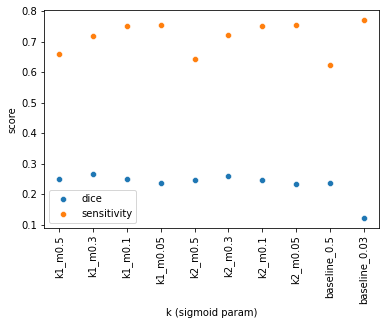

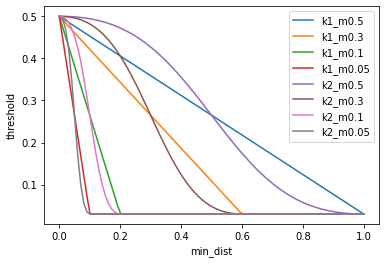

In [61]:
ax = sns.scatterplot(data=pd.DataFrame(res), x='desc', y='dice', label='dice') #, 'sensitivity'))
ax = sns.scatterplot(data=pd.DataFrame(res), x='desc', y='sensitivity', label='sensitivity')
for tick in ax.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.ylabel('score')
plt.xlabel('k (sigmoid param)')
plt.legend()

plt.figure()
for k,m in itertools.product([1,2],[0.5,0.3,0.1,0.05]):
    plt.plot(np.linspace(0,1,100), sigmoid(np.linspace(0,1,100), k=k, m=m), label=f'k{k}_m{m}')
plt.ylabel('threshold')
plt.xlabel('min_dist')
plt.legend()

## Plot predictiond

In [129]:
subjects_to_plot = subjects[1:3]

In [141]:
import matplotlib_surface_plotting as msp
from meld_classifier.meld_plotting import trim
from PIL import Image
def load_predictions_for_subject(subj,save_dirs,
        cohort,):
    #load mask
    s = MeldSubject(subj,cohort=cohort)
    hemi=s.get_lesion_hemisphere()
    dists, label = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
    seg_pred = np.zeros(len(cohort.cortex_mask))
    dist_pred = np.zeros(len(cohort.cortex_mask))
    n_folds = 1
    folds = np.arange(n_folds)
    dp=[]
    sp = []
    for fold in folds:
        save_dir = save_dirs[fold]
        pred_file = os.path.join(save_dir, pred_fname)
        result_hemis = load_prediction(subj,pred_file, dset='prediction')
        seg_pred[cohort.cortex_mask] += result_hemis[hemi]/n_folds
        distance_map = load_prediction(subj,pred_file, dset='distance_map')
        print(distance_map[hemi], distance_map[hemi].max(), distance_map[hemi].min())
        dist_pred[cohort.cortex_mask] += distance_map[hemi]/n_folds
        dp.append(distance_map[hemi])
        sp.append(result_hemis[hemi])
    #file = os.path.join(model_pervertex,f'fold_all', 'results', 'predictions_ensemble_iteration_0.hdf5')
    #per_vertex = np.zeros(len(cohort.cortex_mask))
    #per_vertex[cohort.cortex_mask] = load_prediction(subj,file, dset='prediction')[hemi]
    print(np.sum(np.logical_and(seg_pred>0.09,label>0)))
    return label,seg_pred,dist_pred,dp,sp

[0.82556    0.93195117 0.9191102  ... 0.99493563 0.98829544 0.97874737] 1.1705581 0.3376835
0
[array([0.82556   , 0.93195117, 0.9191102 , ..., 0.99493563, 0.98829544,
       0.97874737], dtype=float32)] 1.1705581 0.3376835
[0.65606207 0.78508437 0.7358574  ... 0.09704857 0.07703902 0.11579025] 1.0075655 -0.03403834
5517
[array([0.65606207, 0.78508437, 0.7358574 , ..., 0.09704857, 0.07703902,
       0.11579025], dtype=float32)] 1.0075655 -0.03403834


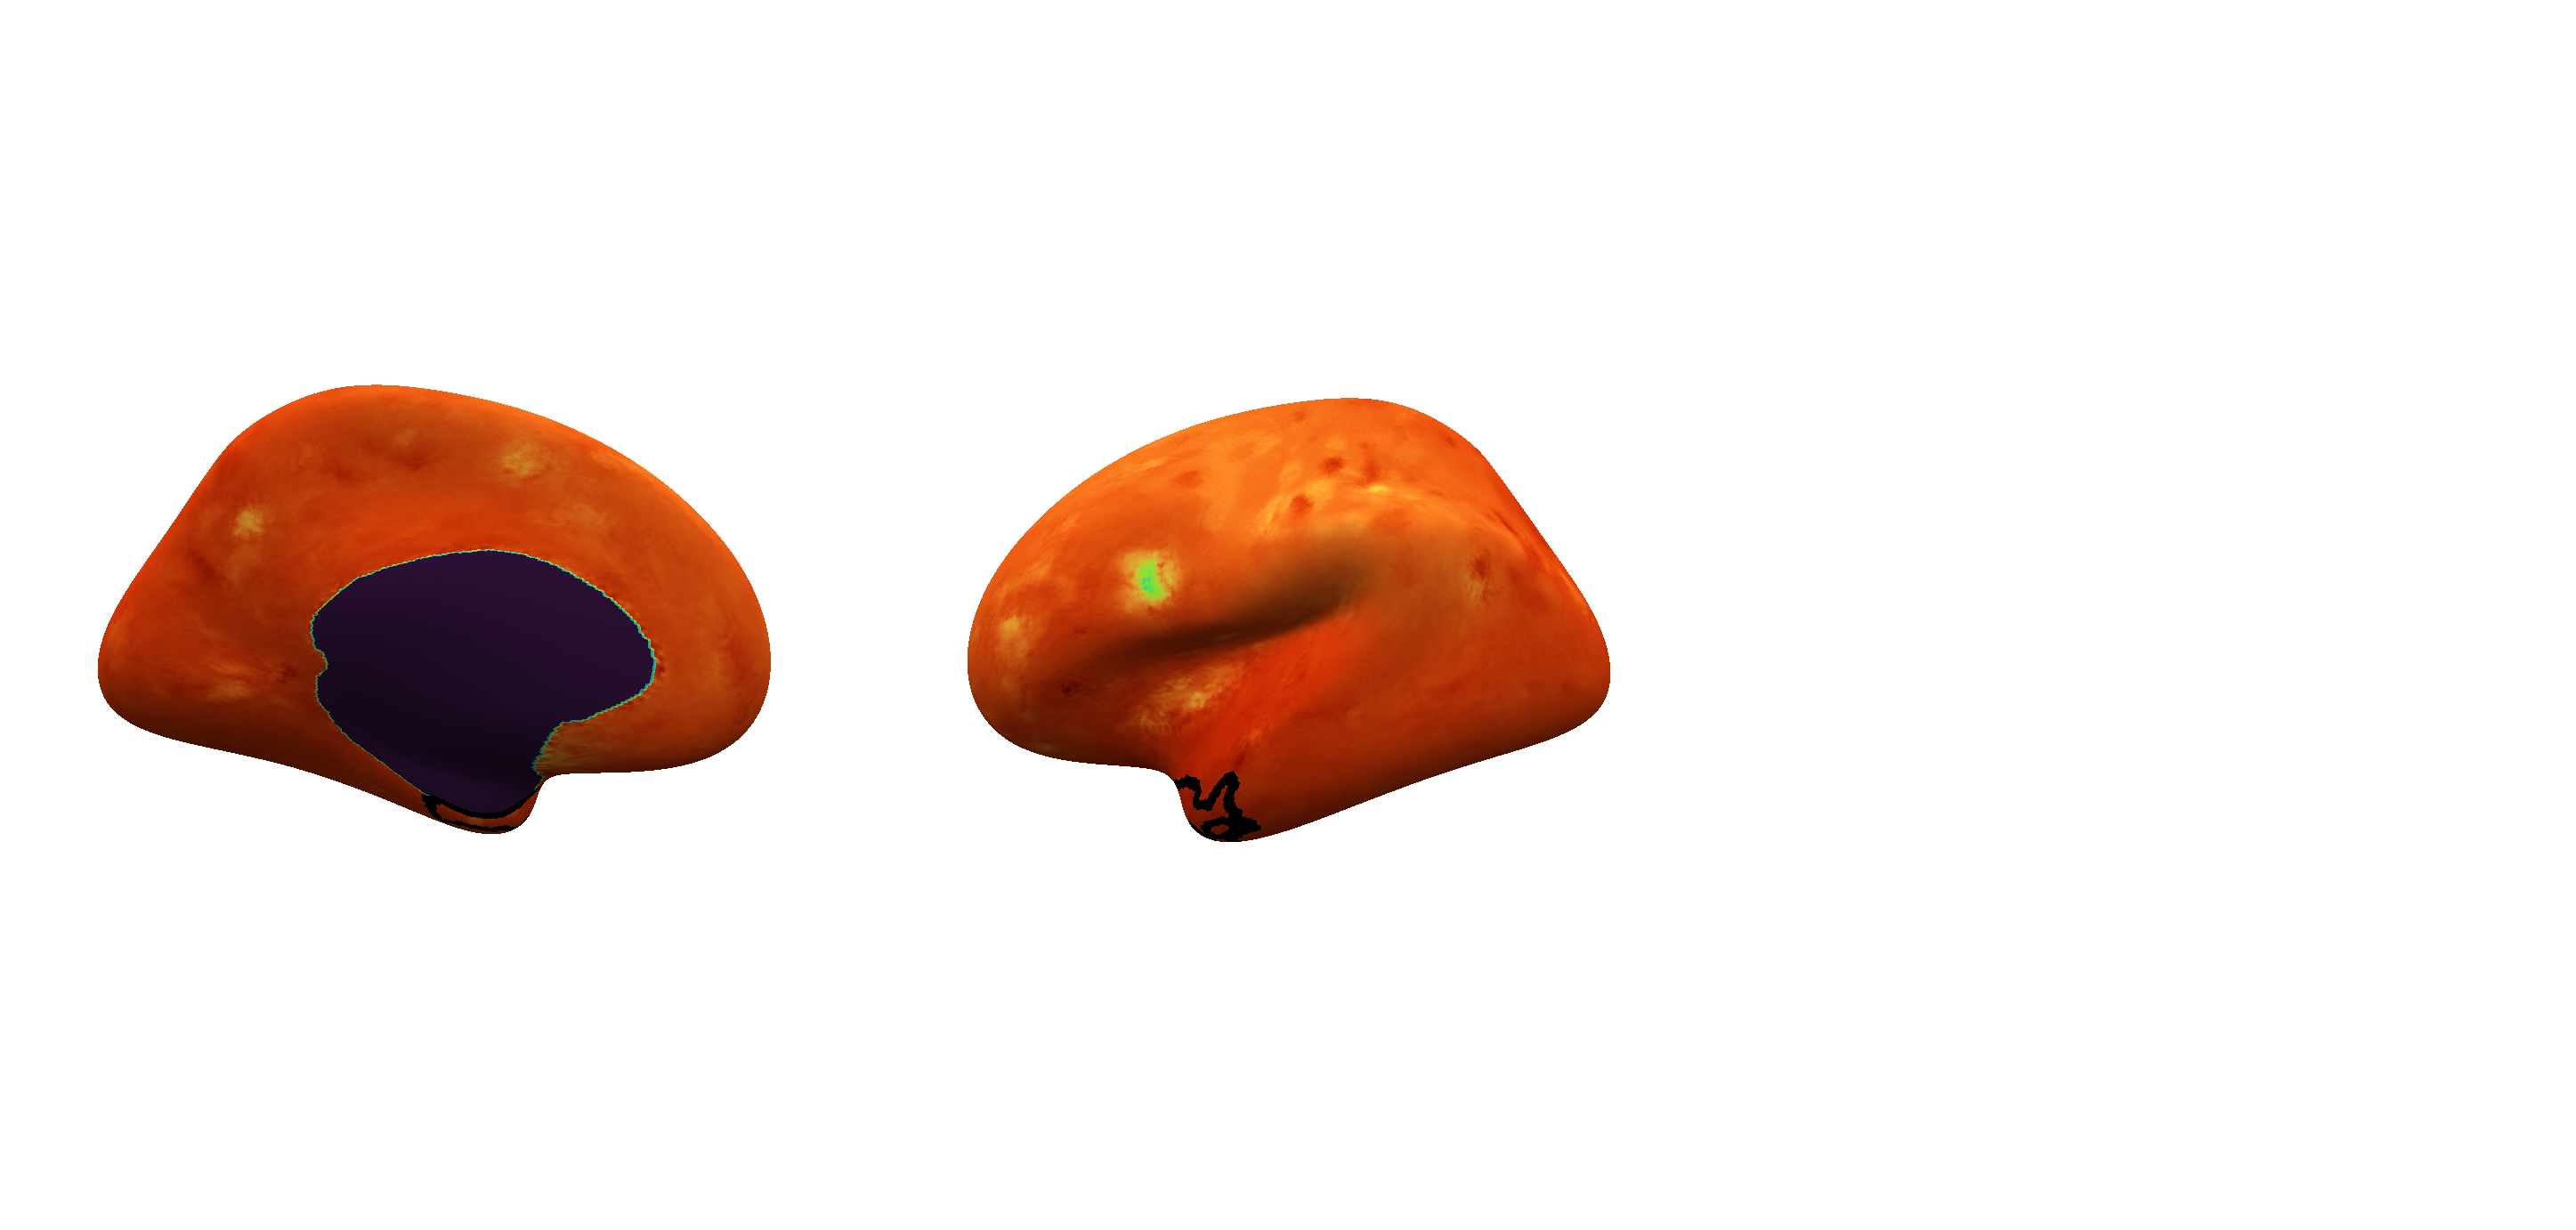

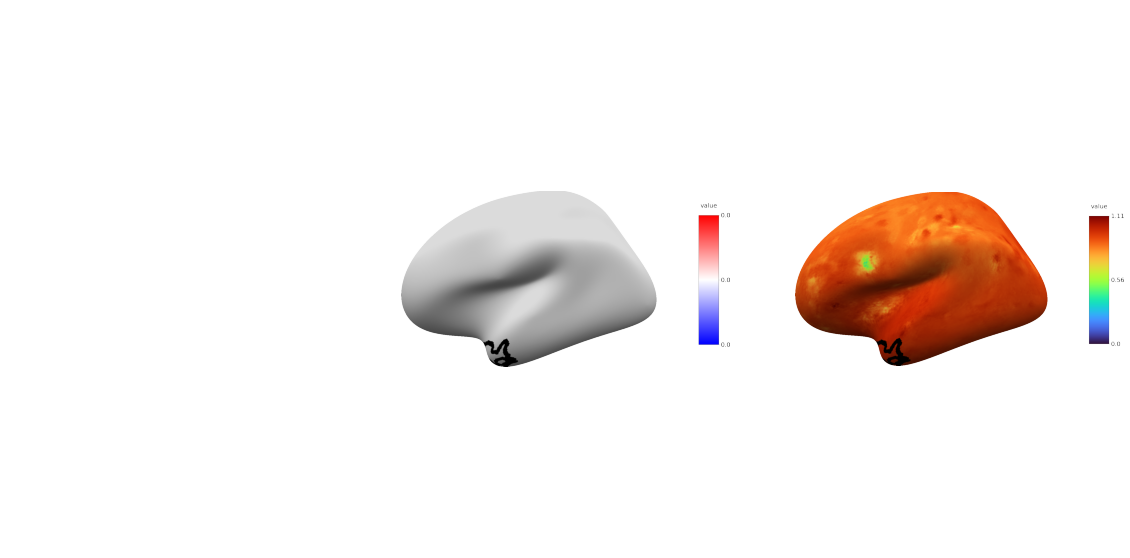

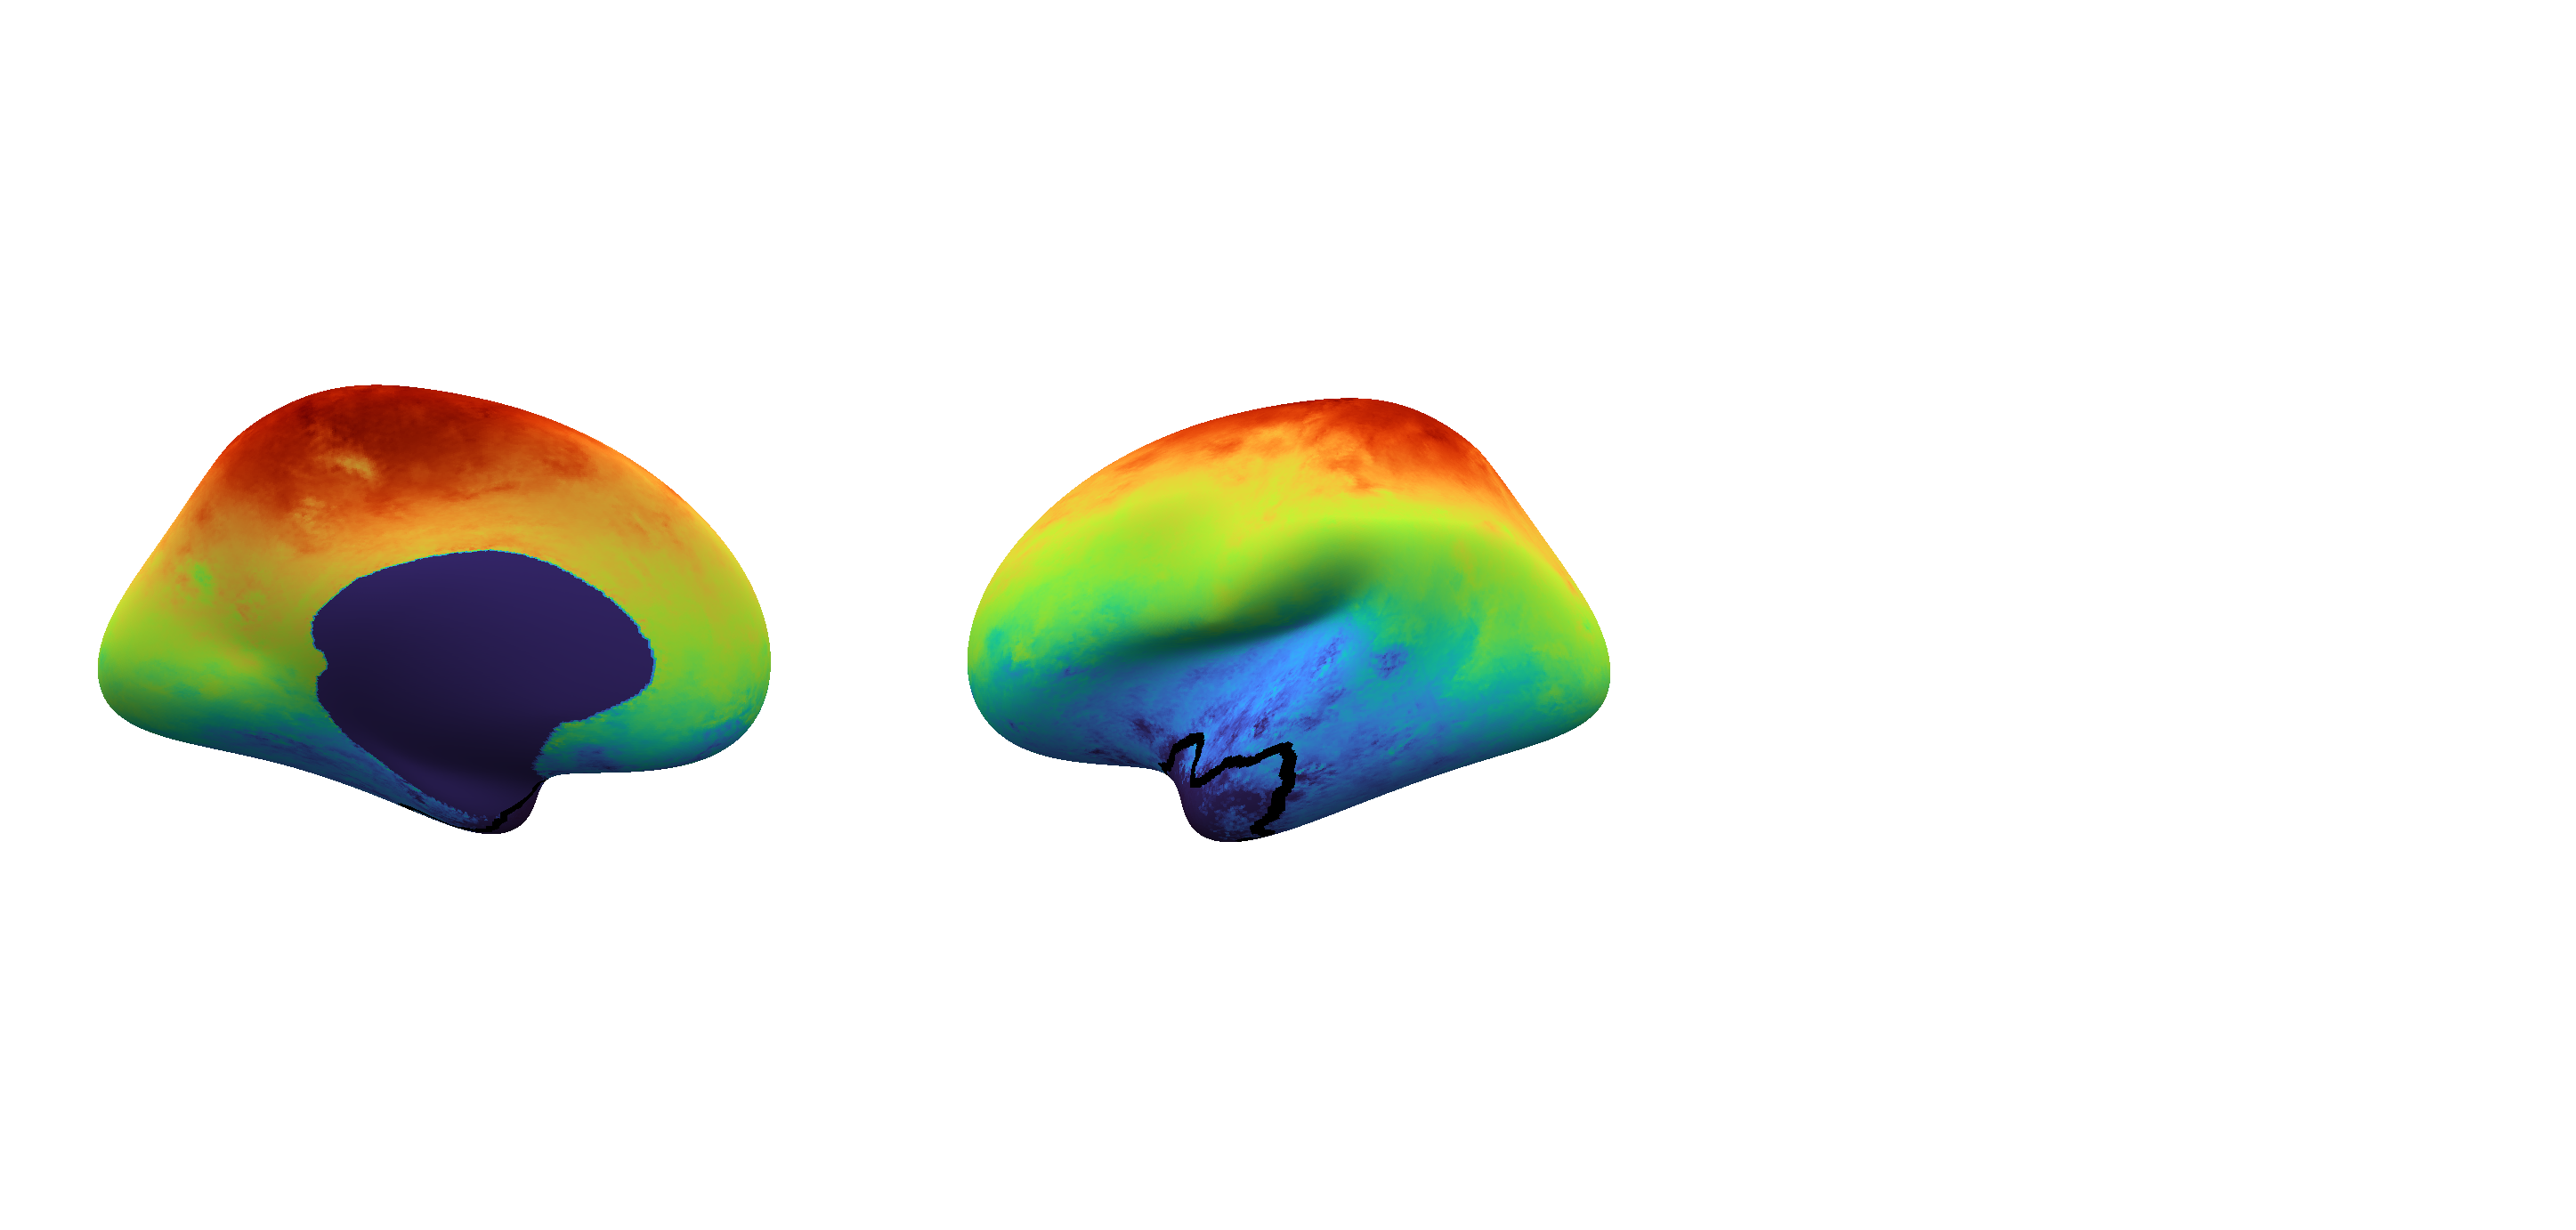

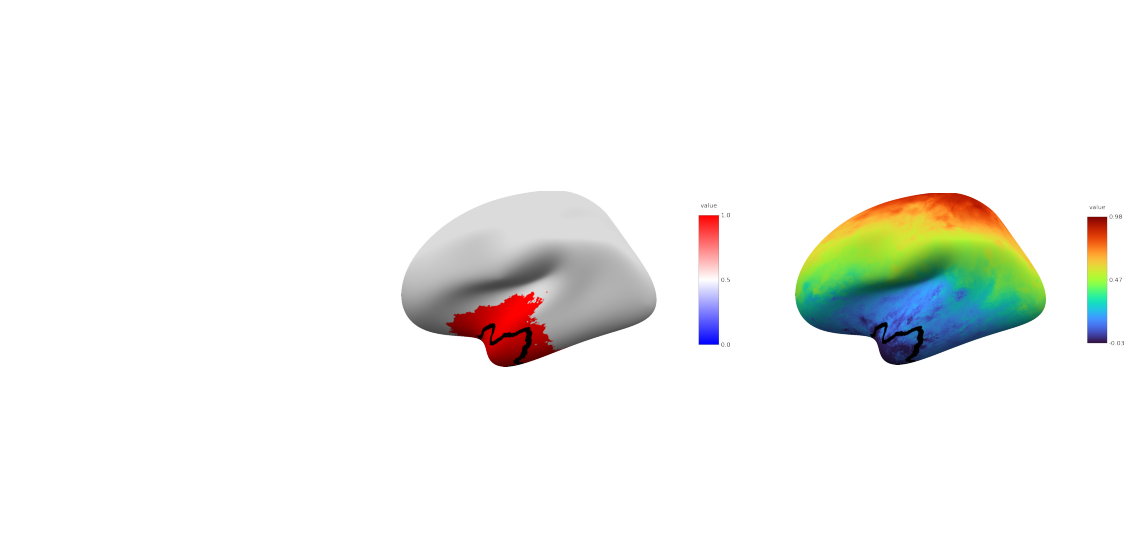

In [142]:
threshold = 0.03
for subj in subjects_to_plot:
    # get predictions and distance maps
    label,seg_pred,dist_pred,dp,sp = load_predictions_for_subject(subj,save_dirs[0:1],cohort)
    print(dp, dp[0].max(), dp[0].min())
    # ensemble distance maps
    for d in dp:
        full_map = np.zeros(len(cohort.cortex_mask))
        full_map[cohort.cortex_mask]=d
        msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],full_map,#rotate=[90],
    cmap='turbo',
    base_size = 20,filename='tmp1.png', colorbar=False,#mask=~per_vertex,
    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})

    #plot predictions using per-vertex graph
    #per_vertex = per_vertex>0
    #msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],per_vertex,rotate=[90],
    #cmap='bwr',
    #base_size = 20,filename='tmp1.png', colorbar=False,mask=~per_vertex,
    #parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    #plt.close()
    #im = Image.open('tmp1.png')
    #trimmed_pv = trim(im)

    #plot predictions new graph and distance
    seg_pred = seg_pred>threshold
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],seg_pred,rotate=[90],
    cmap='bwr',
    base_size = 20,filename='tmp1.png', colorbar=True,mask=~seg_pred,
    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_graph = trim(im)
    msp.plot_surf(cohort.surf['coords'],cohort.surf['faces'],dist_pred,rotate=[90],
    cmap='turbo',
    base_size = 20,filename='tmp1.png', colorbar=True,#mask=~per_vertex,
    parcel=label,parcel_cmap={0:[0,0,0,1],1:[0,0,0,1]})
    plt.close()
    im = Image.open('tmp1.png')
    trimmed_dist = trim(im)

    #combine plots
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    #ax[0].imshow(trimmed_pv)
    ax[1].imshow(trimmed_graph)
    ax[2].imshow(trimmed_dist)
    for ax in ax:
        ax.axis('off')

    #save plot
    #plt.savefig(f'/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/23-03-06_images_MICCAI/examples_patients_fullmodel_{subj}.png', transparent=True)